#### Antibiotic Drug Discovery
#### Corey J Sinnott
# Drug Discovery Modeling

## Executive Summary

This report was commissioned to determine a robust, fast, and reproducible means of searching for, and developing, new antibiotics, in an effort to combat antibiotic resistance. After in-depth analysis, conclusions and recommendations will be presented.
   
Data was obtained from the following source:
- Comprehensive Antibiotic Resistance Database via CARD CLI interface: 
 - https://card.mcmaster.ca
- ChEMBL via Python client library: 
 - https://www.ebi.ac.uk/chembl/ 

**Full Executive Summary, Conclusion, Recommendations, Data Dictionary and Sources can be found in README.**

## Contents:
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Hyperparameter Searching](#Hyperparameter-Searching)
- [Final Models](#Final-Models)

#### Importing Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            mean_squared_error, mean_absolute_error, r2_score,\
                            plot_confusion_matrix, classification_report, \
                            plot_roc_curve, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import set_config
from tqdm.notebook import tqdm

#### Data Import and Preparation

In [88]:
df = pd.read_csv('./data/acinetobacter_baumannii_MIC_addFeats_addBits.csv').drop(columns = 'Unnamed: 0')

In [5]:
df.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
7442,Cc1c(CNC2CCCCC2)cc(-c2ccc(C(C)C)cc2)n1-c1ccc(C...,128.00,inactive,0,intermediate,421.03,7.65,1.00,2.00,0,...,0,0,0,0,0,0,0,0,0,0
3967,CC(C)(O/N=C(\C(=O)N[C@@H]1C(=O)N(S(=O)(=O)O)[C...,16.00,active,1,active,586.56,-1.35,7.00,13.00,1,...,0,0,0,0,0,0,0,0,0,0
7666,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,0.03,active,1,active,822.95,4.34,6.00,15.00,0,...,0,0,0,0,0,0,0,1,0,0


Creating a scaled target

In [90]:
df['pMIC'] = df['standard_value'].map(lambda x: -np.log10(x * (10**-9)))

In [7]:
#first test with subset not containing intermediate efficacy
df_bin_class = df[df.bioactivity_multiclass != 'intermediate']

In [8]:
df_bin_class.bioactivity_multiclass.value_counts()

active      3633
inactive    2564
Name: bioactivity_multiclass, dtype: int64

#### Scaling distribution:

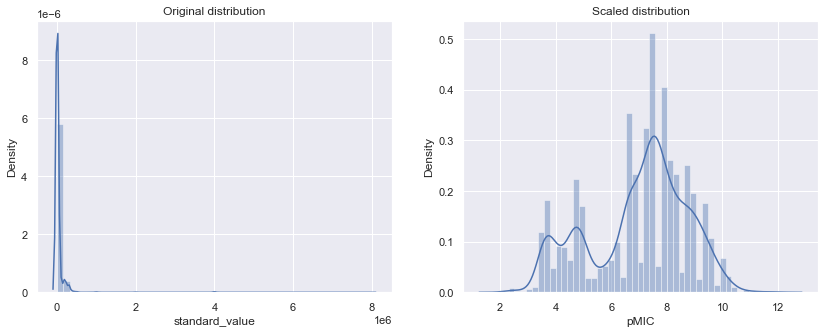

In [9]:
sns.set(style = 'darkgrid', context = 'notebook')
fig, ax = plt.subplots(1, 2, figsize = (14,5))
sns.distplot(df.standard_value, ax = ax[0]).set_title('Original distribution'); 
sns.distplot(df.pMIC, ax = ax[1]).set_title('Scaled distribution');

Testing progress bar function

In [2]:
from tqdm.notebook import tqdm_notebook
import time
example_iter = [1,2,3,4,5]
for rec in tqdm_notebook(example_iter):
    time.sleep(.1)

  0%|          | 0/5 [00:00<?, ?it/s]

# Hyperparameter Searching

## Regression

*Scaled distribution*

In [84]:
def regression_eval(y, y_train, y_test, y_pred):
    """
    """
    null_y = np.full_like(y_train, y.mean())
        
    print(' __________________ ')
    print(f'|Null MSE = {np.round(mean_squared_error(y_train, null_y), 3)}  |')
    print('|------------------|')
    print(f'|   MSE   = {np.round(mean_squared_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   RMSE  = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}  |')
    print('|------------------|')
    print(f'|   MAE   = {np.round(mean_absolute_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   r^2   = {np.round(r2_score(y_test, y_pred), 3)}  |')
    print(' ------------------ ')

In [109]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y = df['pMIC']

In [110]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X[num_cols] = ss.fit_transform(X[num_cols])

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Testing progress bar function and exploring n_estimators

In [16]:
parameter_n_estimators = [100,500,1000]

for i in tqdm(parameter_n_estimators):
  model = RandomForestRegressor(n_estimators=i)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  regression_eval(y, y_train, y_test, y_pred)

  0%|          | 0/3 [00:00<?, ?it/s]

 ______________ 
Null MSE = 3.092 |
|--------------|
|   MSE  = 0.886 |
|--------------|
|   RMSE = 0.942 |
|--------------|
|   MAE  = 0.657 |
|--------------|
|   r^2  = 0.712 |
 -------------- 
 ______________ 
Null MSE = 3.092 |
|--------------|
|   MSE  = 0.888 |
|--------------|
|   RMSE = 0.942 |
|--------------|
|   MAE  = 0.658 |
|--------------|
|   r^2  = 0.711 |
 -------------- 
 ______________ 
Null MSE = 3.092 |
|--------------|
|   MSE  = 0.887 |
|--------------|
|   RMSE = 0.942 |
|--------------|
|   MAE  = 0.657 |
|--------------|
|   r^2  = 0.712 |
 -------------- 


In [66]:
RFR = RandomForestRegressor()
#ss = StandardScaler()

In [67]:
#pipe = make_pipeline(ss, RFR)

In [68]:
RFR_params = {
    'ccp_alpha': [0, 0.0001, 3],
    #'randomforestregressor__oob_score': [True, False], 
    'n_estimators': [100] #increasing n_estimators did not benefit
}

In [73]:
grid_rfr = GridSearchCV(RFR, RFR_params, verbose = 3, n_jobs = -1)

In [74]:
%%time
grid_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  4.5min remaining: 12.4min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  4.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.3min finished


CPU times: user 1min 53s, sys: 1.47 s, total: 1min 54s
Wall time: 8min 13s


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.0001, 3], 'n_estimators': [100]},
             verbose=3)

In [75]:
y_pred = grid_rfr.predict(X_test)

In [85]:
regression_eval(y, y_train, y_test, y_pred)

 __________________ 
|Null MSE = 3.064  |
|------------------|
|   MSE   = 0.892  |
|------------------|
|   RMSE  = 0.944  |
|------------------|
|   MAE   = 0.644  |
|------------------|
|   r^2   = 0.718  |
 ------------------ 


In [77]:
grid_rfr.best_params_

{'ccp_alpha': 0, 'n_estimators': 100}

Percent improvement over null model:

In [112]:
null_y = np.full_like(y_train, y.mean())

null_MSE = np.round(mean_squared_error(y_train, null_y), 3)
MSE = np.round(mean_squared_error(y_test, y_pred), 3)

print(f'Percent improvement = {(np.abs(np.round(((null_MSE - MSE) / null_MSE), 3)))*100}%')

Percent improvement = 72.1%


*Original distribution*

In [113]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y = df['standard_value']

In [114]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X[num_cols] = ss.fit_transform(X[num_cols])

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [94]:
RFR = RandomForestRegressor()
#ss = StandardScaler()

In [16]:
#pipe = make_pipeline(ss, RFR)

In [95]:
RFR_params = {
    'ccp_alpha': [0, 0.001, 2],
    #'randomforestregressor__oob_score': [True, False], 
    'n_estimators': [200]
}

In [96]:
grid_rfr_2 = GridSearchCV(RFR, RFR_params, verbose = 3, n_jobs = -1)

In [97]:
%%time
grid_rfr_2.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 13.7min remaining: 37.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 13.8min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 20.6min finished


CPU times: user 8min 25s, sys: 1.51 s, total: 8min 26s
Wall time: 29min 5s


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.001, 2], 'n_estimators': [200]},
             verbose=3)

In [100]:
y_pred_2 = grid_rfr_2.predict(X_test)

In [101]:
regression_eval(y, y_train, y_test, y_pred_2)

 __________________ 
|Null MSE = 40964791307.287  |
|------------------|
|   MSE   = 15990477739.867  |
|------------------|
|   RMSE  = 126453.461  |
|------------------|
|   MAE   = 23400.69  |
|------------------|
|   r^2   = 0.724  |
 ------------------ 


Percent improvement over null model:

In [117]:
null_y = np.full_like(y_train, y.mean())

null_MSE = np.round(mean_squared_error(y_train, null_y), 3)
MSE = np.round(mean_squared_error(y_test, y_pred_2), 3)

print(f'Percent improvement = {(np.abs(np.round(((null_MSE - MSE) / null_MSE), 3)))*100}%')

Percent improvement = 69.39999999999999%


Standardized target ~3% lower MSE

## Classification

In [45]:
def classification_eval(y_test, y_pred):
    """
    """
    #print(f'null accuracy = {np.round(max(y_test.mean(), 1 - y_test.mean()), 3)}')
    print(f'    accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'    precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'    recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'    f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'    roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')

In [49]:
X = df_bin_class.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass', 'pMIC'])
y = df_bin_class['bioactivity_binary_class']

In [50]:
ss = StandardScaler()
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']
X[num_cols] = ss.fit_transform(X[num_cols])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
RFC_params = {
#     'randomforestclassifier__n_estimators' : [100],
#     'randomforestclassifier__ccp_alpha' : [0.0, 0.01, 1, 3],
#     'randomforestclassifier__min_samples_leaf' : [0, 1, 4],
#     'randomforestclassifier__criterion' : ['gini', 'entropy']
    'n_estimators' : [100],
    'ccp_alpha' : [0.0, 0.01, 1, 3],
    'min_samples_leaf' : [0, 1, 4],
    'criterion' : ['gini', 'entropy']
}

In [53]:
RFC = RandomForestClassifier()
#ss = StandardScaler()

In [54]:
#pipe_class = make_pipeline(ss, RFC)

In [55]:
grid_rfc = GridSearchCV(RFC, RFC_params, verbose = 3)

In [56]:
%%time
grid_rfc.fit(X_train, y_train, n_jobs = -1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=0, n_estimators=100, score=nan, total=   0.1s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100, score=0.949, total=   3.2s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100, score=0.947, total=   3.2s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100, score=0.939, total=   3.3s
[CV] ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100 
[CV]  ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, n_estimators=100, score=0.944, total=   3.4s
[CV] ccp_alpha=0.0, cr

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.5min finished


CPU times: user 3min 29s, sys: 4.53 s, total: 3min 33s
Wall time: 3min 35s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.01, 1, 3],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [0, 1, 4], 'n_estimators': [100]},
             verbose=3)

In [57]:
y_preds = grid_rfc.predict(X_test)

In [58]:
grid_rfc.score(X_train, y_train), grid_rfc.score(X_test, y_test)

(0.9687970733806757, 0.9425806451612904)

In [59]:
classification_eval(y_test, y_preds)

    accuracy  = 0.943
    precision = 0.941
    recall    = 0.965
    f1-score  = 0.953
    roc auc   = 0.937


In [61]:
grid_rfc.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'min_samples_leaf': 1,
 'n_estimators': 100}

# Final Models

Regression with Standardized Target

In [ ]:
def regression_and_eval(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    null_y = np.full_like(y_train, y.mean())
    model = model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(' __________________ ')
    print(f'|Null MSE = {np.round(mean_squared_error(y_train, null_y), 3)}  |')
    print('|------------------|')
    print(f'|   MSE   = {np.round(mean_squared_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   RMSE  = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}  |')
    print('|------------------|')
    print(f'|   MAE   = {np.round(mean_absolute_error(y_test, y_pred), 3)}  |')
    print('|------------------|')
    print(f'|   r^2   = {np.round(r2_score(y_test, y_pred), 3)}  |')
    print(' ------------------ ')
    
    return model

Binary Classification

In [ ]:
def classification_and_eval(X, y, model, params):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model = model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 3)}')
    print(f'    accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'    precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'    recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'    f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'    roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    
    return model